# 二八轮动

二八轮动，指的是市值最大的前 20% 数量的大盘股和剩下数目占 80% 的中小盘股之间的轮动。经典二八轮动策略的主要驱动逻辑是动量。动量就是资产近期涨幅的横向排名，它与趋势很像，但多了一层横向比较：看谁过去涨得多或跌得少，然后就买谁。

二八轮动假设了市场资金的流动是有惯性的：当近期大盘股涨得多的时候，后续大概率资金还会持续地向大盘股流入；直到这个趋势难以持续下去的时候，资金又会向小盘股流动，而且这个趋势一旦开始，资金就又会一直往小盘股流入。


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
# %run ./shared/tools.py

from shared.tools import get_drawdown, cal_period_perf_indicator, datestr2dtdate


def backtest_result(df):
    ret_df = df.loc[:, ['hs300', 'csi500', 'stgy']]

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(2, 1, 1)
    ret_df.plot(ax=ax1, grid=True)
    plt.xlim(df.index[0], df.index[-1])

    ax2 = fig.add_subplot(2, 1, 2)
    df[['pos_300', 'pos_500']].plot(ax=ax2, kind='area', stacked=True, grid=True)
    plt.xlim(df.index[0], df.index[-1])

    res = cal_period_perf_indicator(ret_df)
    res['TotalRet'] = ret_df.iloc[-1] - 1
    print(res)

加载测试数据

In [3]:
index_price = pd.read_csv('./res/指数历史数据.csv').set_index('datetime')
index_price.index = [datestr2dtdate(e) for e in index_price.index]

设置回测参数

In [4]:
N = 21

start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2022, 12, 31)

下面回测以沪深 300 指数和中证 500 指数为交易标的，其中沪深 300 指数代表大盘股，中证 500 指数代表中小盘股。每天回看这两个指数最近 N 个交易日的涨幅，当沪深 300 的区间涨幅大于中证 500 时，持有沪深 300；当中证 500 的区间涨幅大于沪深 300 时，持有中证 500。

## 二八轮动：满仓版本

          AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
hs300  -0.016334  0.203249 -0.080364 -0.395856 -0.041262 -0.047688
csi500  0.042582  0.210388  0.202395 -0.315704  0.134878  0.131701
stgy    0.078803  0.202887  0.388408 -0.285495  0.276022  0.252383


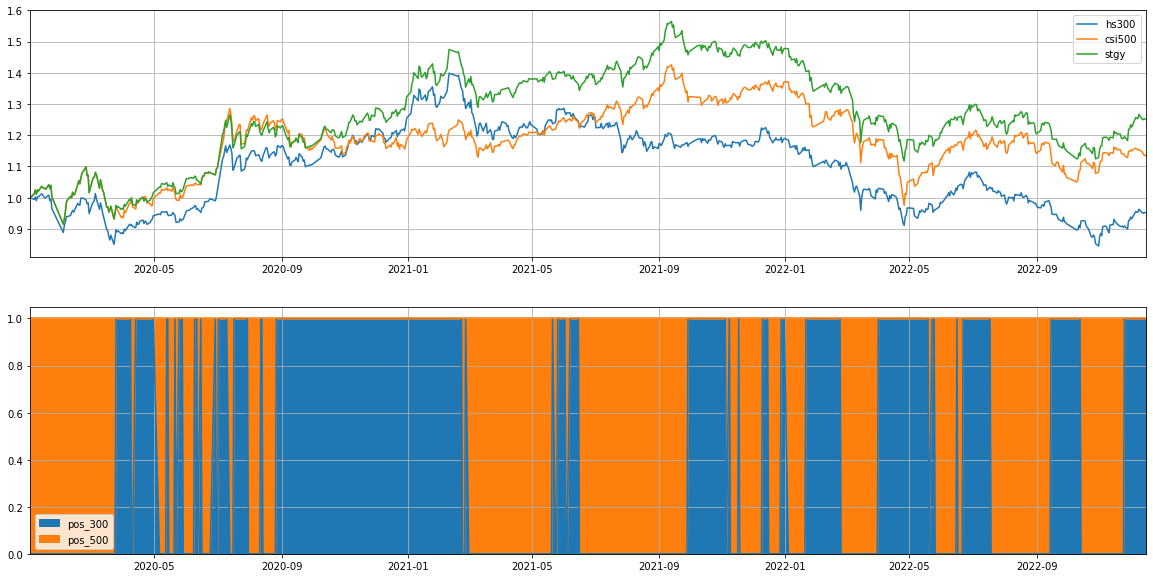

In [5]:
df = index_price.copy()
df = df.loc[start_date:end_date]
df['ret_300'] = df['hs300'].pct_change()
df['ret_500'] = df['csi500'].pct_change()
df['N_day_ret_300'] = df['hs300'] / df['hs300'].shift(N) - 1
df['N_day_ret_500'] = df['csi500'] / df['csi500'].shift(N) - 1
# 设置仓位：在 300 还是 500 ？
df['momentum_300_vs_500'] = df['N_day_ret_300'] - df['N_day_ret_500']
df['pos_300'] = [1 if e > 0 else 0 for e in df['momentum_300_vs_500'].shift(1)]
df['pos_500'] = 1 - df['pos_300']
# 计算获利
df['ret_stgy'] = df['ret_300'] * df['pos_300'] + df['ret_500'] * df['pos_500']
df['hs300'] = (1 + df['ret_300']).cumprod().fillna(1)
df['csi500'] = (1 + df['ret_500']).cumprod().fillna(1)
df['stgy'] = (1 + df['ret_stgy']).cumprod().fillna(1)

backtest_result(df)

In [6]:
# df.iloc[100:150]

<hr />

## 二八轮动：可空仓版

总是满仓版本的二八轮动虽然性价比很高，但回撤水平仍然不是普通个人投资者能接受的。可以空仓的版本，它与前面版本的唯一差异就是，当回看 N 个交易日涨幅时，如果两个指数均为下跌，就选择空仓。

          AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
hs300  -0.016334  0.203249 -0.080364 -0.395856 -0.041262 -0.047688
csi500  0.042582  0.210388  0.202395 -0.315704  0.134878  0.131701
stgy    0.050737  0.148123   0.34253 -0.176707  0.287123  0.158166


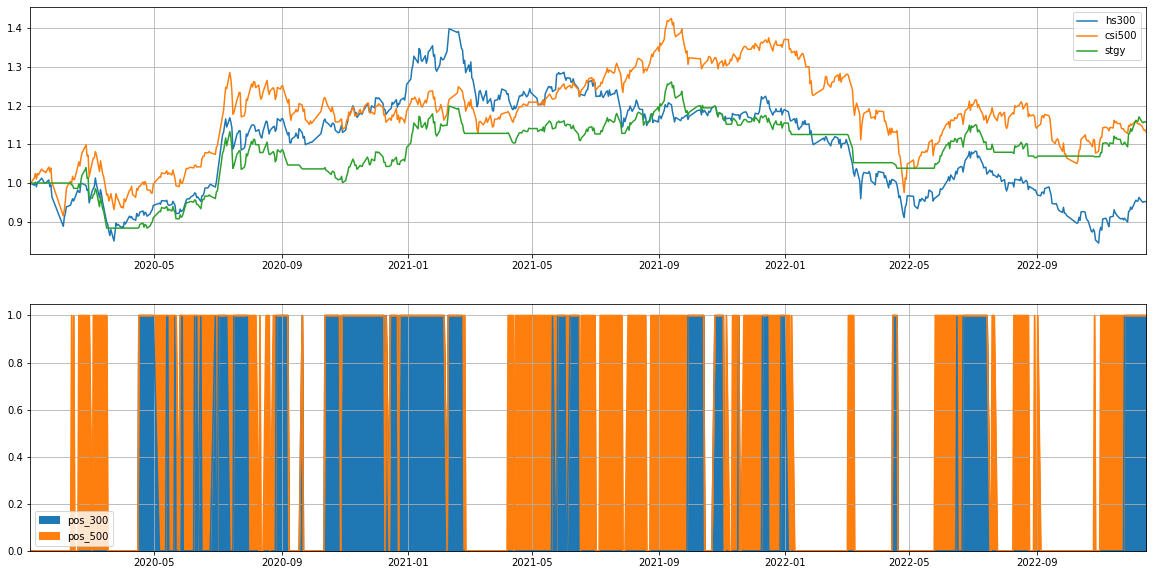

In [7]:
df = index_price.copy()
df = df.loc[start_date:end_date]
df['ret_300'] = df['hs300'].pct_change()
df['ret_500'] = df['csi500'].pct_change()
df['N_day_ret_300'] = df['hs300'] / df['hs300'].shift(N) - 1
df['N_day_ret_500'] = df['csi500'] / df['csi500'].shift(N) - 1

# 仓位设置：空仓时 两个 pos 都为 0
df['pos_300'] = 0
df['pos_500'] = 0
for i in range(1, len(df)):
    t = df.index[i]
    t0 = df.index[i - 1]
    if df.loc[t0, 'N_day_ret_300'] >= df.loc[t0, 'N_day_ret_500'] and df.loc[t0, 'N_day_ret_300'] > 0:
        df.loc[t, 'pos_300'] = 1
    elif df.loc[t0, 'N_day_ret_500'] > df.loc[t0, 'N_day_ret_300'] and df.loc[t0, 'N_day_ret_500'] > 0:
        df.loc[t, 'pos_500'] = 1

# 计算获利
df['ret_stgy'] = df['ret_300'] * df['pos_300'] + df['ret_500'] * df['pos_500']
df['hs300'] = (1 + df['ret_300']).cumprod().fillna(1)
df['csi500'] = (1 + df['ret_500']).cumprod().fillna(1)
df['stgy'] = (1 + df['ret_stgy']).cumprod().fillna(1)

backtest_result(df)

美中不足：因为策略会空仓，所以 2019 到 2020 两年的慢牛行情中获利不多——这是降低最大回撤的合理代价。
<hr />

## 二八轮动：变体版

——满仓和可空仓结合体，基于股市温度决定使用满仓版还是可空仓版。

股市温度由 沪深 300 收益率 和 十年期国债 比值 T 来衡量:
- T >= 3 : 股市温度低，也就是寒冬，非常有吸引力
- T <= 1.8 : 股市温度很高，大夏天，风险高于回报了，不具有吸引力

[T 值参考](http://www.dashiyetouzi.com/tools/compare/hs300_10gz_pro.php)

          AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
hs300  -0.016334  0.203249 -0.080364 -0.395856 -0.041262 -0.047688
csi500  0.042582  0.210388  0.202395 -0.315704  0.134878  0.131701
stgy    0.092453  0.193569  0.477624 -0.251924  0.366989  0.299987


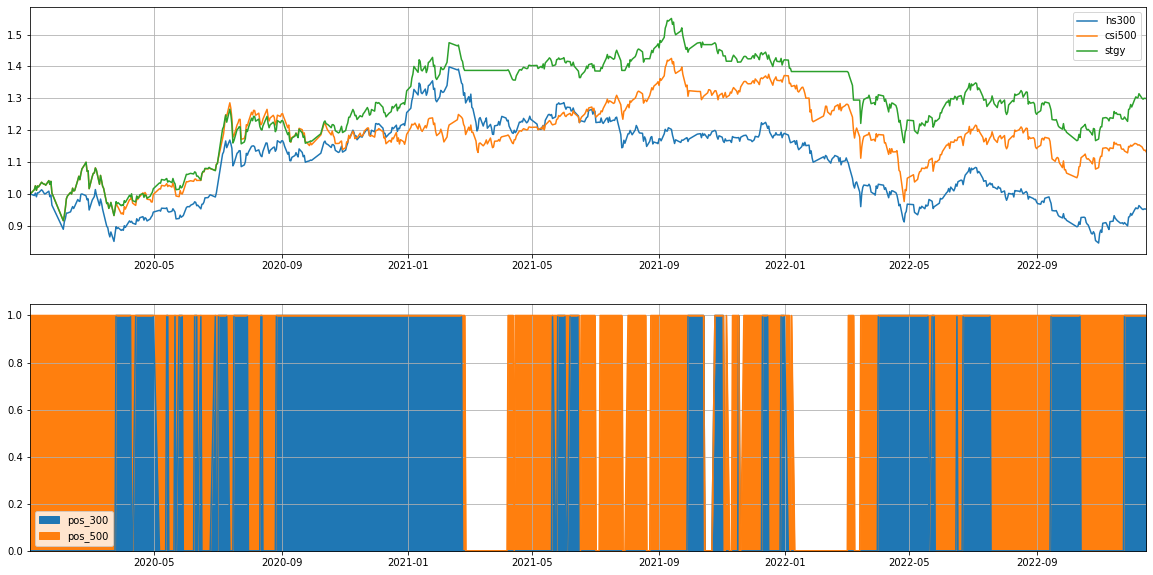

In [8]:
# T 值的区间
t_date_range = [
    datetime.date(2010, 10, 11),
    datetime.date(2012, 8, 31),
    datetime.date(2015, 4, 7),
    datetime.date(2016, 1, 14),
    datetime.date(2017, 10, 30),
    datetime.date(2019, 1, 2),
    datetime.date(2021, 2, 9),
    datetime.date(2022, 3, 14),
]

df = index_price.copy()
df = df.loc[start_date:end_date]
df['ret_300'] = df['hs300'].pct_change()
df['ret_500'] = df['csi500'].pct_change()
df['N_day_ret_300'] = df['hs300'] / df['hs300'].shift(N) - 1
df['N_day_ret_500'] = df['csi500'] / df['csi500'].shift(N) - 1

df['momentum_300_vs_500'] = df['N_day_ret_300'] - df['N_day_ret_500']
df['pos_300'] = [1 if e > 0 else 0 for e in df['momentum_300_vs_500'].shift(1)]
df['pos_500'] = 1 - df['pos_300']

# 可空仓区间：T <= 1.8
for i in range(1, len(df)):
    t = df.index[i]
    if t <= t_date_range[1] or (t >= t_date_range[2] and t <= t_date_range[3]) \
        or (t >= t_date_range[4] and t <= t_date_range[5]) \
        or (t >= t_date_range[6] and t <= t_date_range[7]):
        t0 = df.index[i - 1]
        if df.loc[t0, 'N_day_ret_300'] >= df.loc[t0, 'N_day_ret_500'] and df.loc[t0, 'N_day_ret_300'] > 0:
            df.loc[t, 'pos_300'] = 1
        elif df.loc[t0, 'N_day_ret_500'] > df.loc[t0, 'N_day_ret_300'] and df.loc[t0, 'N_day_ret_500'] > 0:
            df.loc[t, 'pos_500'] = 1
        else:
            df.loc[t, 'pos_300'] = 0
            df.loc[t, 'pos_500'] = 0

# 计算获利
df['ret_stgy'] = df['ret_300'] * df['pos_300'] + df['ret_500'] * df['pos_500']
df['hs300'] = (1 + df['ret_300']).cumprod().fillna(1)
df['csi500'] = (1 + df['ret_500']).cumprod().fillna(1)
df['stgy'] = (1 + df['ret_stgy']).cumprod().fillna(1)

backtest_result(df)